In [1]:
%matplotlib inline
import salvus.namespace as sn
from scipy.io import savemat
import salvus.flow.simple_config as sc
import pathlib
import salvus.flow.simple_config as config
import matplotlib.pyplot as plt
import xarray as xr
import os
import cv2
from scipy.signal import hilbert, chirp
import obspy
from os.path import join as pjoin
from natsort import natsorted, ns
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import h5py
import numpy as np
import salvus.namespace as sn
from pathlib import Path
import salvus.mesh.unstructured_mesh as um
from typing import List
import salvus.flow.simple_config as config
from salvus.mesh.tools import transforms
from salvus.mesh.tools import transforms
cwd = os.getcwd()

SALVUS_FLOW_SITE_NAME = os.environ.get("SITE_NAME", "tcplatt")

/home/abtin/anaconda3/envs/salvus/lib/python3.11/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/abtin/anaconda3/envs/salvus/lib/python3.11/site-packages/paramiko/transport.py:256: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,



   ┌────────────────────────────────────────────────────────────────────────────────────┐
   │                                                                                    │
   │   Salvus update available!                                                         │
   │                                                                                    │
   │   2024.1.1 → 2024.1.3                                                              │
   │                                                                                    │
   │   See https://mondaic.com/docs/updates/changelog                                   │
   │   for a list of changes and new features.                                          │
   │                                                                                    │
   │   To upgrade, please first make sure that your python environment is up to date:   │
   │                                                                                    │
   │   ht

/tmp/ipykernel_30259/584676231.py:2: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  import salvus.namespace as sn


--> Server: 'https://l.mondaic.com/licensing_server', User: 'alexander.jung', Group: 'TH_Deggendorf'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.64 seconds]


In [2]:
!rm -rf project_folder
# !rm -rf data

In [3]:
# Read mesh from Exodus file.
mesh = um.UnstructuredMesh.from_exodus("Shot26.e")  ## 1 danach
mesh.points[:] *= 0.001

In [4]:
mesh_ref = transforms.uniformly_refine(mesh=mesh, tensor_order=4, refinement_order=8)
mesh_ref 

In [5]:
mesh_ref

In [6]:
mesh_ref.attach_field("elastic", np.zeros(mesh_ref.nelem))

mesh_ref.find_side_sets()
# Attach parameters (elastic).
pars = {"VP": 6315.8,"VS": 3129.3, "RHO": 2582.8}
template = np.ones_like(mesh_ref.get_element_nodes()[:, :, 0])
for key, value in pars.items():
    mesh_ref.attach_field(key, template * value)

mesh_ref

In [7]:
freq_res = mesh_ref.compute_resolved_frequency(vmin=mesh_ref.element_nodal_fields["VS"].min(axis=1),elements_per_wavelength=1.5)
freq_res[1].min()

1553230.5315331025

In [8]:
domain = sn.domain.dim2.BoxDomain(x0=-0.10, x1=0.2, y0=-0.02, y1=0.02)
p = sn.Project.from_domain(domain=domain, path="project_folder", load_if_exists=True)

Accordion()

In [9]:
wav=np.load('wavelet_threeCycles.npy')

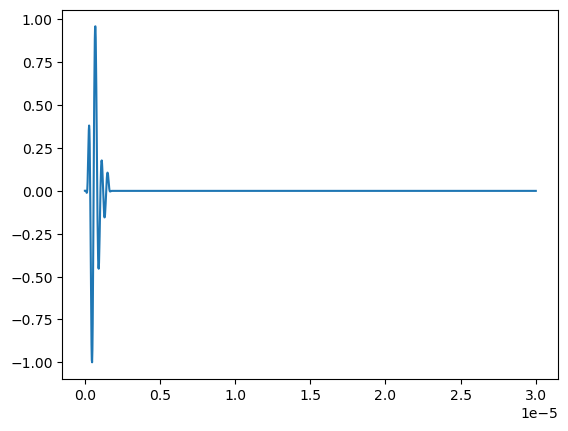

In [10]:
plt.plot(wav[0,:],wav[1,:])

In [11]:
wavefilt=wav[1,:]

In [12]:
steep=200
lentrans=100
x = np.linspace(-steep, steep, lentrans)
z = 1/(1 + np.exp(-x))
z=z[round(lentrans*0.39):round(lentrans*0.61)]
z[1e-02>z]=0
taper=np.ones(np.shape(wavefilt)[0])
taper[:len(z)] = z
taper[-len(z):] = np.flip(z)
wavefilt=wavefilt*taper

In [13]:
stf_custom = config.stf.Custom.from_array(
            wav[1,:],
            sampling_rate_in_hertz=50000000.0,
            start_time_in_seconds=0.2e-6
            )

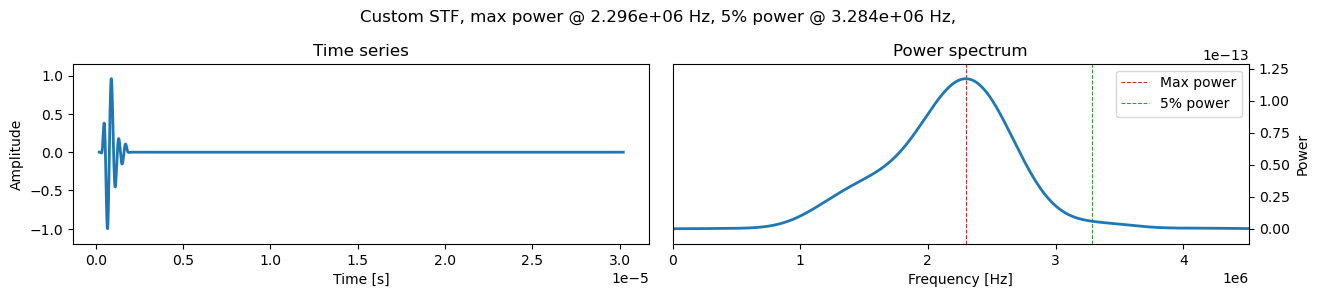

In [14]:
wsc = sn.WaveformSimulationConfiguration(end_time_in_seconds=1.0e-05)
wsc.physics.wave_equation.courant_number = 0.5 #Zeitschritt kleiner machen default 0,6
ec = sn.EventConfiguration(
    wavelet=stf_custom,
    waveform_simulation_configuration=wsc,
)
ec.wavelet.plot()

In [15]:
num_transducers=393
dx = 0.0005
x_positions=np.zeros(num_transducers)
np.shape(x_positions)
for i in range(num_transducers):
    x_positions[i]=-0.09850+ i * dx

In [16]:
receivers = [
    sn.simple_config.receiver.cartesian.Point2D(
        x=x,
        y=0.02,
        station_code=f"receiver_{i + 1:04}",
        fields=["displacement"],
    )
    for i, x in enumerate(x_positions)
]

events = [
    sn.Event(
        event_name=f"shot_{i + 1:04}",
        sources=[
            sn.simple_config.source.cartesian.VectorPoint2D(x=x, y=0.02, fx=0,fy=1e-1)
        ],
        receivers=receivers[i],
    )
    for i, x in enumerate(x_positions)
]


In [17]:
for e in events:
    p.add_to_project(e)

In [18]:
#import salvus.flow.simple_config as config
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name="external_mesh", unstructured_mesh=mesh_ref, event_configuration=ec,
    )
)

In [19]:
p.viz.nb.simulation_setup(
    simulation_configuration="external_mesh", events=p.events.list()
)

In [43]:
p.simulations.launch(
    "external_mesh",
    #events=p.events.list()[::10],
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=1,
)
p.simulations.query(block=True)

[2025-03-06 16:33:33,739] INFO: Submitting job array with 393 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/393 [00:00<?, ?job/s]

VBox()

True

In [44]:
p.viz.nb.waveforms(
    ["external_mesh"], receiver_field="displacement"
)

In [45]:
print(f"Iteration {itt}: array shape = {array.shape}")

NameError: name 'itt' is not defined

In [46]:
list_sorted=natsorted(p.events.list())

ed = p.waveforms.get("external_mesh", events=[list_sorted[0]])
i=0
st = obspy.Stream()
for _ in range(1): # only one event....
    for r in ed.events[_].receiver_name_list:
        st.extend(
           ed.events[i].get_receiver_data(receiver_name=r, receiver_field="displacement")
           )
    i+=1

st = st.select(component = "Y")
result = obspy.Stream()
desired_sampling_rate = 100000000.0
for tr in st:
    sr = tr.stats.sampling_rate
    tr.stats.sampling_rate = 1.0
    down_sample = tr.interpolate(
        method="lanczos", a=12, sampling_rate=desired_sampling_rate / sr
    )
    result.append(down_sample)
    tr.stats.sampling_rate = desired_sampling_rate

    array_ges = np.asarray(result)

array_ges=np.zeros((393,393,980))
for itt in range(0,len(list_sorted)):

    ed = p.waveforms.get("external_mesh", events=[list_sorted[itt]])
    i=0
    st = obspy.Stream()
    for _ in range(1): # only one event....
        for r in ed.events[_].receiver_name_list:
            st.extend(
               ed.events[i].get_receiver_data(receiver_name=r, receiver_field="displacement")
               )
        
        i+=1

    st = st.select(component = "Y")
    result = obspy.Stream()
    desired_sampling_rate = 100000000.0
    
    for tr in st:
        sr = tr.stats.sampling_rate
        tr.stats.sampling_rate = 1.0
        down_sample = tr.interpolate(
            method="lanczos", a=12, sampling_rate=desired_sampling_rate / sr
        )
        result.append(down_sample)
        tr.stats.sampling_rate = desired_sampling_rate

        array = np.asarray(result)
    array_ges[itt,:,:]=array[:,0:980] ## 
   # array_ges=np.concatenate((array_ges, array), axis=0)

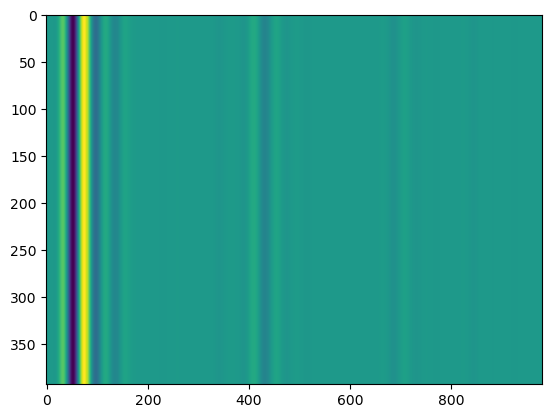

In [47]:
## FMC: Sources, receiver, time

plt.imshow(array_ges[8,:,:], interpolation='nearest', aspect='auto')

In [48]:
np.shape(array_ges)

(393, 393, 980)

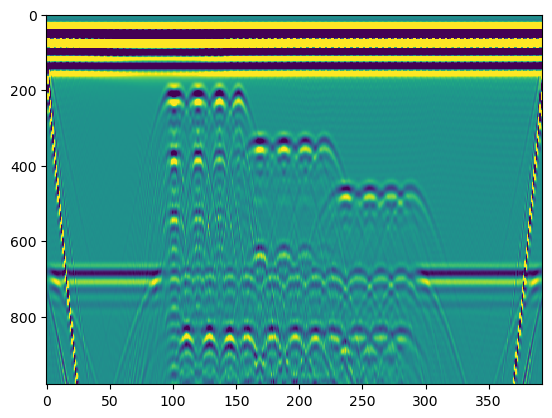

In [49]:
## FMC: Sources, receiver, time

plt.imshow(array_ges[:,0,:].T, interpolation='nearest', aspect='auto')
plt.clim(-0.1e-12,0.1e-12)

In [50]:
np.save("datatraces.npy", array_ges)

In [51]:
dataneu = np.load("./datatraces.npy")

In [52]:
dataneu1=np.zeros([400,400,980],dtype=np.complex_)
for g in range(393):
    for t in range(393):
        analytic_signal=hilbert(dataneu[g,t,:])
        dataneu1[g,t,:]=np.abs(analytic_signal)

In [53]:
np.shape(array_ges)

(393, 393, 980)

In [54]:
x_positions

array([-0.0985, -0.098 , -0.0975, -0.097 , -0.0965, -0.096 , -0.0955,
       -0.095 , -0.0945, -0.094 , -0.0935, -0.093 , -0.0925, -0.092 ,
       -0.0915, -0.091 , -0.0905, -0.09  , -0.0895, -0.089 , -0.0885,
       -0.088 , -0.0875, -0.087 , -0.0865, -0.086 , -0.0855, -0.085 ,
       -0.0845, -0.084 , -0.0835, -0.083 , -0.0825, -0.082 , -0.0815,
       -0.081 , -0.0805, -0.08  , -0.0795, -0.079 , -0.0785, -0.078 ,
       -0.0775, -0.077 , -0.0765, -0.076 , -0.0755, -0.075 , -0.0745,
       -0.074 , -0.0735, -0.073 , -0.0725, -0.072 , -0.0715, -0.071 ,
       -0.0705, -0.07  , -0.0695, -0.069 , -0.0685, -0.068 , -0.0675,
       -0.067 , -0.0665, -0.066 , -0.0655, -0.065 , -0.0645, -0.064 ,
       -0.0635, -0.063 , -0.0625, -0.062 , -0.0615, -0.061 , -0.0605,
       -0.06  , -0.0595, -0.059 , -0.0585, -0.058 , -0.0575, -0.057 ,
       -0.0565, -0.056 , -0.0555, -0.055 , -0.0545, -0.054 , -0.0535,
       -0.053 , -0.0525, -0.052 , -0.0515, -0.051 , -0.0505, -0.05  ,
       -0.0495, -0.0

In [55]:
mesh_dim =[480,240] 
spacing = 0.00075;     
transpos=x_positions+0.024625;  
#transpos=x_positions+0.030625; 
sR = 1/100000000.0


resolution = 0.0001; # (meters)     
# Assuming wave speed
V=6315.8;  #(m/s) 

sL = 980

nC  = 64

yn = np.arange(0, mesh_dim[1]*resolution,resolution).reshape(-1,1)
xn = np.arange(0, mesh_dim[0]*resolution,resolution).reshape(-1,1)
yn_sq = (yn**2).reshape(1,-1) 
im = np.zeros((len(yn),len(xn)),dtype=np.complex_)
np.shape(im)

s=spacing
s=transpos*1
d=sR
#eps=0.00000036
eps=0
for i in range(393):
    #for i in range(nC-1):
    for j in range(393):
        #for j in range(i+1,nC):
    # Calculate t matrix
        t = np.round((((np.sqrt((xn-s[j] - d)**2+yn_sq))+(np.sqrt((xn-s[i]-d)**2+yn_sq)))/V+eps)/sR)
        # Mask T matrix to discard out of range values (values bigger than sL) and add the correct signal to the image
        t[t>=sL] = -2
        t= t.astype(int).T
 
        im += np.ma.array(dataneu[j,i,t]*(1/(1+abs(i-j))), mask = t==-2)

In [56]:
im=np.abs(im)

In [57]:
im=(im-np.min(im))/(np.max(im)-np.min(im))

Text(0, 0.5, 'distance in mm')

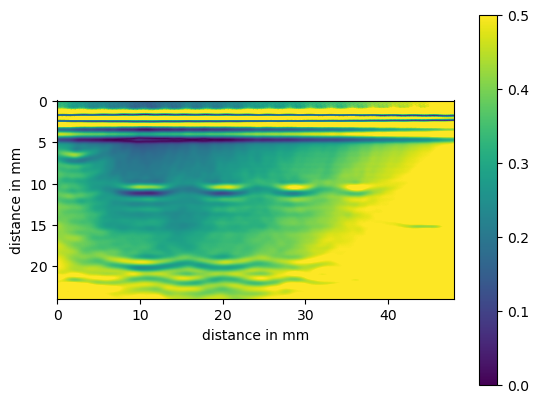

In [58]:
plt.imshow(im)

# Add colorbar
plt.colorbar()

# Adjust the color limits of the image
for ima in plt.gca().get_images():
    ima.set_clim(0, 0.5)

# Define x-tick positions and corresponding labels
xrange = list(range(0, 48))[0::10]
yrange = list(range(0, 24))[0::5]

# Set x-ticks and labels
plt.xticks(ticks=[i * 10 for i in xrange], labels=xrange)
plt.yticks(ticks=[i *10 for i in yrange], labels=yrange)

# Set x and y labels
plt.xlabel('distance in mm')

plt.ylabel('distance in mm')

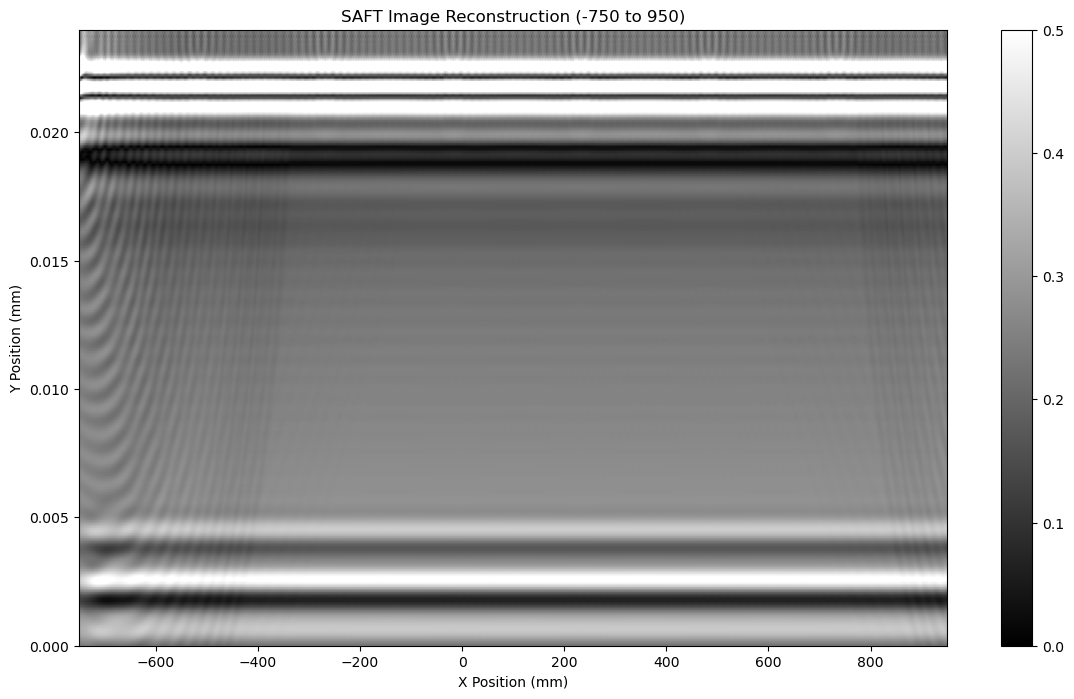

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Define Mesh and Parameters
mesh_dim = [1345+355, 240]  # Adjusted for new range (-750 to 950)
spacing = 0.0005  # (meters)
resolution = 0.0001  # (meters)
V = 6315.8  # (m/s) wave speed
sL = 1700  # Scan length from -750 to 950

nC = 393  # Number of Channels

# Assuming x_positions is defined before this script
transpos = x_positions + 0.024625  # Adjusted transducer positions

sR = 1 / 100000000.0  # Sampling Rate
eps = 0  # Small correction factor

# Generate Grid
yn = np.arange(0, mesh_dim[1] * resolution, resolution).reshape(-1, 1)
xn = np.arange(-355 * resolution, 1345 * resolution, resolution).reshape(-1, 1)  # New range
yn_sq = (yn ** 2).reshape(1, -1)

# Initialize Image Matrix
im = np.zeros((len(yn), len(xn)), dtype=np.complex_)

# Set Transducer Spacing
s = spacing
s = transpos * 1
d = sR

# SAFEGUARD: Ensure array_ges exists and is of expected shape
if "array_ges" not in locals():
    raise ValueError("Error: 'array_ges' is not defined. Ensure you have loaded or generated the data.")

# SAFEGUARD: Ensure array_ges has the correct dimensions
if len(array_ges.shape) < 3 or array_ges.shape[0] < nC or array_ges.shape[1] < nC:
    raise ValueError("Error: 'array_ges' shape is incorrect. Expected at least (393, 393, time_samples).")

# SAFT Reconstruction Loop
for i in range(nC):
    for j in range(nC):
        # Calculate Time Matrix
        t = np.round((((np.sqrt((xn - s[j] - d) ** 2 + yn_sq)) + 
                       (np.sqrt((xn - s[i] - d) ** 2 + yn_sq))) / V + eps) / sR)

        # Clip Out-of-Bounds Values to Ensure Index Safety
        t = np.clip(t, 0, array_ges.shape[2] - 1).astype(int).T

        # Apply Mask and Weighting
        im += np.ma.array(array_ges[j, i, t] * (1 / (1 + abs(i - j))), mask=(t >= sL))
im=np.abs(im)
im=(im-np.min(im))/(np.max(im)-np.min(im))
# Normalize Image Data Safely
#im = np.abs(im)
#im_min, im_max = np.min(im), np.max(im)
#if im_max > im_min:
    #im = (im - im_min) / (im_max - im_min)
#else:
    #im = np.zeros_like(im)"
im=np.abs(im)
im=(im-np.min(im))/(np.max(im)-np.min(im))
# Display Image
fig, ax = plt.subplots(figsize=(14, 8))  # Increase figure size
ima = ax.imshow(im, cmap='gray', aspect='auto', extent=[-750, 950, 0, mesh_dim[1] * resolution])  # Adjust extent
ima.set_clim(0, 0.5)  # Set color limits
plt.colorbar(ima)  # Add colorbar
plt.title("SAFT Image Reconstruction (-750 to 950)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# Optional: Save image for debugging


In [51]:
from PIL import Image
import numpy as np

# Assuming 'im' is your array with shape (270, 1700)
# Normalize the array to 8-bit range (0-255)
im_normalized = ((im - im.min()) / (im.max() - im.min()) * 255).astype(np.uint8)

# Convert to PIL Image in grayscale mode
image = Image.fromarray(im_normalized, mode='L')

# Save as TIFF file
image.save("Alu_saft_1.tif", format="TIFF")

In [41]:
mesh_dim =[980,240] 
spacing = 0.0005;     
transpos=x_positions+0.024625;  
#transpos=x_positions+0.030625; 
sR = 1/100000000.0


resolution = 0.0002; # (meters)     
# Assuming wave speed
V=6315.8;  #(m/s) 

sL = 980

nC  = 393

yn = np.arange(0, mesh_dim[1]*resolution,resolution).reshape(-1,1)
xn = np.arange(0, mesh_dim[0]*resolution,resolution).reshape(-1,1)
yn_sq = (yn**2).reshape(1,-1) 
im = np.zeros((len(yn),len(xn)),dtype=np.complex_)
np.shape(im)

s=spacing
s=transpos*1
d=sR
#eps=0.00000036
eps=0
for i in range(393):
    #for i in range(nC-1):
    for j in range(393):
        #for j in range(i+1,nC):
    # Calculate t matrix
        t = np.round((((np.sqrt((xn-s[j] - d)**2+yn_sq))+(np.sqrt((xn-s[i]-d)**2+yn_sq)))/V+eps)/sR)
        # Mask T matrix to discard out of range values (values bigger than sL) and add the correct signal to the image
        t[t>=sL] = -2
        t= t.astype(int).T
 
        im += np.ma.array(array_ges[j,i,t]*(1/(1+abs(i-j))), mask = t==-2) 
im=np.abs(im)
im=(im-np.min(im))/(np.max(im)-np.min(im))
import numpy as np
import matplotlib.pyplot as plt

# Load your image (assuming it is a grayscale image with shape (393, 980))


# Create the figure and axis
fig, ax = plt.subplots()

# Display the image in grayscale format ('gray' colormap)
ima = ax.imshow(im, cmap='gray')

# Set the color limits as requested
ima.set_clim(0, 0.5)

# Show the image
plt.colorbar(ima)  # Optional: Adds a colorbar for reference
plt.show()

KeyboardInterrupt: 

In [152]:
im=np.abs(im)

In [153]:
im=np.abs(im)
im=(im-np.min(im))/(np.max(im)-np.min(im))

In [37]:
print(im.shape)

(240, 1960)


TypeError: Image data of dtype complex128 cannot be converted to float

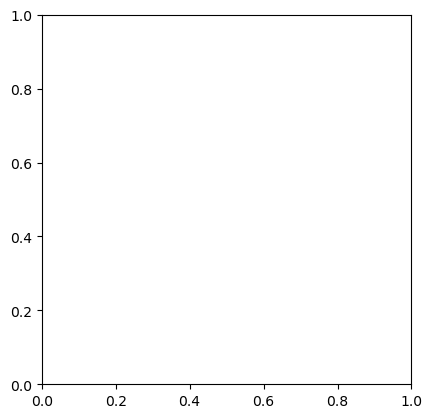

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Load your image (assuming it is a grayscale image with shape (393, 980))


# Create the figure and axis
fig, ax = plt.subplots()

# Display the image in grayscale format ('gray' colormap)
ima = ax.imshow(im, cmap='gray')

# Set the color limits as requested
ima.set_clim(0, 0.5)

# Show the image
plt.colorbar(ima)  # Optional: Adds a colorbar for reference
plt.show()

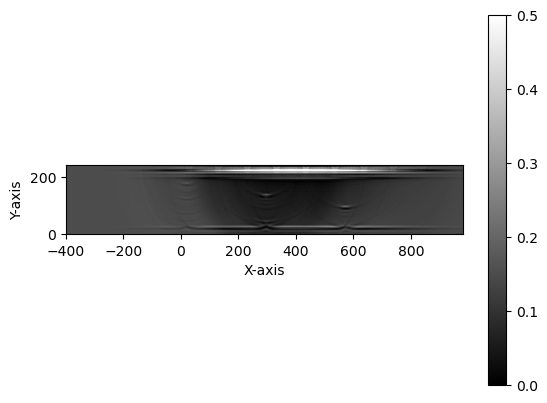

In [35]:
# Create the figure and axis
fig, ax = plt.subplots()

# Display the image in grayscale format ('gray' colormap)
ima = ax.imshow(im, cmap='gray', extent=[-400, 980, 0, im.shape[0]])

# Set the color limits as requested
ima.set_clim(0, 0.5)

# Set axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the colorbar for reference
plt.colorbar(ima)

# Show the image
plt.show()

Text(0, 0.5, 'distance in mm')

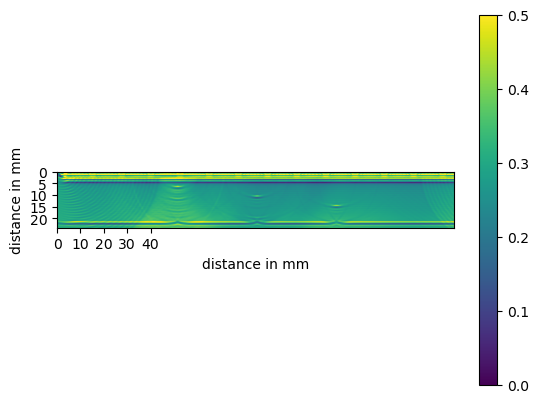

In [45]:
plt.imshow(im)

# Add colorbar
plt.colorbar()

# Adjust the color limits of the image
for ima in plt.gca().get_images():
    ima.set_clim(0, 0.5)

# Define x-tick positions and corresponding labels
xrange = list(range(0, 48))[0::10]
yrange = list(range(0, 24))[0::5]

# Set x-ticks and labels
plt.xticks(ticks=[i * 10 for i in xrange], labels=xrange)
plt.yticks(ticks=[i *10 for i in yrange], labels=yrange)

# Set x and y labels
plt.xlabel('distance in mm')

plt.ylabel('distance in mm')

In [105]:

mdic = {"dataneu": dataneu}

savemat("sim_data.mat", mdic)